Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.1) 나무위키 최신 변경 문서의 키워드 분석

### 바로가기

- [<Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기](#<Step1.-크롤링>-:-크롤링으로-웹-데이터-가져오기)
    - [BeautifulSoup을 이용한 웹 크롤링]
    - [나무위키 최근변경 데이터 크롤링]
- [<Step2. 추출> : 키워드 추출](#<Step2.-추출>-:-키워드-추출)
    - [텍스트 데이터 전처리]
    - [말뭉치 만들기]
    - [konlpy를 이용한 키워드 추출]
    - [키워드 가다듬기]
- [<Step3. 시각화> : 워드 클라우드 시각화](#<Step3.-시각화>-:-워드-클라우드-시각화)
    - [pytagcloud 사용하기]
    - [나무위키 키워드 시각화]

-----

In [ ]:
맥 OS, 리눅스 OS의 경우 /Users/yoonk/anaconda3/envs/pybook/lib/python3.7/site-packages/ pytagcloud/fonts의 경로에 위와 동일한 방법을 적용해줍니다.

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기

### [BeautifulSoup을 이용한 웹 크롤링]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `pip install selenium`
    - (env_name) `pip install beautifulsoup4`
- 혹은 아래의 코드로 라이브러리를 설치합니다.

In [2]:
!pip install selenium beautifulsoup4

-----

##### 페이지 리스트 가져오기

In [3]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re

# brew 로 설치된 chromedriver의 path (Mac)
path = "/usr/local/bin/chromedriver"

# 윈도우용 크롬 웹드라이버 실행 경로 (Windows)
excutable_path = "chromedriver.exe"

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://namu.wiki/RecentChanges"

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
# driver = webdriver.Chrome(path)  # for Mac
driver = webdriver.Chrome(executable_path=excutable_path)  # for Windows
driver.get(source_url)
req = driver.page_source
soup = BeautifulSoup(req, "html.parser")
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

In [4]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all("td")[0]
    td_url = first_td.find_all("a")
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get("href")
        if "png" not in page_url:
            page_urls.append(page_url)

# 중복 url을 제거합니다.
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

# 크롤링에 사용한 브라우저를 종료합니다.
driver.close()

https://namu.wiki/w/%EC%9D%B4%EC%84%BC%EB%93%9C%EB%9D%BC
https://namu.wiki/w/%EC%B2%AD%EC%95%84%EA%B7%B8%EB%A3%B9
https://namu.wiki/w/%ED%95%9C%EA%B5%ADGM%20%EB%9D%BC%EB%B3%B4
https://namu.wiki/w/%EA%B2%BD%EC%9F%81
https://namu.wiki/w/%ED%8B%80:2021%EB%85%84%20%EC%84%B8%EA%B3%84%20%EC%98%81%ED%99%94%20%ED%9D%A5%ED%96%89%20%EC%88%9C%EC%9C%84


-----

##### 페이지내 텍스트 구조 확인

In [5]:
# driver = webdriver.Chrome(path)  # for Mac
driver = webdriver.Chrome(executable_path=excutable_path)  # for Windows
driver.get(page_urls[0])
req = driver.page_source
soup = BeautifulSoup(req, 'html.parser')
contents_table = soup.find(name="article")
title = contents_table.find_all('h1')[0]
category = contents_table.find_all('ul')[0]
content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
content_corpus_list = []

for paragraphs in content_paragraphs:
    content_corpus_list.append(paragraphs.text)
content_corpus = "".join(content_corpus_list)

print(title.text)
print("\n")
print(category.text)
print("\n")
print(content_corpus)

# 크롤링에 사용한 브라우저를 종료합니다.
driver.close()

이센드라 


디아블로 시리즈/등장인물


이센드라  Isendra종족인간성별여성소속잔 에수직업원소술사상태사망관계발데크(스승이자 친구), 리밍(제자), 줄 · 카시아(동료)[1]등장디아블로 2  디아블로 2: 파괴의 군주  디아블로 3: 영혼을 거두는 자  불나방성우리아나 영(디아블로 2), 제시카 스트라우스(영어판 디아블로 3)1. 개요2. 작중 행적2.1. 디아블로 22.2. 불나방2.3. 영혼을 거두는 자디아블로 시리즈의 등장인물. 디아블로 2의 직업 중 하나인 원소술사의 설정상 인물이다.잔 에수 마법단 출신의 원소술사 플레이어블 캐릭터로 등장. 그 유명한 소서리스다.악마가 창궐하기 시작하는 칸두라스로 건너가 로그 캠프에서 네 명의 동료를 만나 악의 근원으로 지목되는 어둠의 방랑자를 쫒기 시작한다. 동문 성채를 지키는 안다리엘, 탈 라샤의 무덤을 지키는 두리엘, 그리고 메피스토까지 처치하고 마지막엔 지옥까지 쫒아서 아이단 왕자를 숙주로 삼은 디아블로를 처치하는 데 성공한다.직후 마지막 남은 바알을 마무리하기 위해 하로가스에 도착해 새로운 동료 드루이드와 암살자를 만난다. 이렇게 총 일곱 명의 영웅들이 힘을 합쳐 결국은 바알까지 쓰러뜨리고 잠시 동안 대악마가 없는 세상을 만드는 데 성공한다. 익히 아는 디아블로 2의 스토리 전반을 이끌어 온 인물.디아블로 3 이전의 스토리를 담은 단편 소설 불나방에서 등장한다. 이샤리 성소에서 수습생들과 결투를 벌이고 있는(사실상 일방적으로 공격한) 한 소녀를 스승이자 친구인 발데크에게 데려오는 장면으로 시작된다.리밍(히어로즈 오브 더 스톰)이라는 이 소녀는 자신이 '마법사'라며 신들 조차 할 수 없는 일들을 할 수 있다며 이센드라와 발데크 앞에서 기고만장해 하는데, 발데크가 뛰어난 언변으로 리밍에게 자신을 가르쳐 달라는 말을 꺼내게 만든다. 그리곤 이센드라가 자신이 이 소녀의 스승이 되겠다며 직접 나선다. 계속 티격태격대던 터라 리밍은 단칼에 이센드라를 거절하고 발데크에게 배우겠다고 하지만 결국 리밍을 제자로 받아들이게 

-----

### [나무위키 최근변경 데이터 크롤링]

In [6]:
# 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비합니다.
columns = ["title", "category", "content_text"]
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만듭니다.
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
    # driver = webdriver.Chrome(path)  # for Mac
    driver = webdriver.Chrome(executable_path=excutable_path)  # for Windows
    driver.get(page_url)
    req = driver.page_source
    soup = BeautifulSoup(req, "html.parser")
    contents_table = soup.find(name="article")
    title = contents_table.find_all("h1")[0]
    
    # 카테고리 정보가 없는 경우를 확인합니다.
    if len(contents_table.find_all("ul")) > 0:
        category = contents_table.find_all("ul")[0]
    else:
        category = None
        
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
    
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서 “분류”라는 단어와 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
    
    # 모든 정보를 하나의 데이터 프레임에 저장합니다.
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)
    
    # 크롤링에 사용한 브라우저를 종료합니다.
    driver.close()

In [7]:
# 데이터 프레임을 출력합니다.
df.head(5)

,title,category,content_text
0,이센드라,디아블로 시리즈/등장인물,이센드라 Isendra종족인간성별여성소속잔 에수직업원소술사상태사망관계발데크(스승이...
1,청아그룹,펜트하우스 시리즈/설정,[ 시리즈 ] 펜트하우스 시리즈 펜트하우스→펜트하우스 II→펜트하우스 III 펜트...
2,한국GM 라보,대우자동차/생산차량한국GM/생산차량트럭경상용차1991년 출시2021년 단종,1. 개요2. 상세3. 여담4. 경쟁 차량5. 둘러보기6. 관련 문서DAEWOO /...
3,경쟁,한자어,1. 정의1.1. 사회학적 정의1.2. 생물학적 정의2. 일상에서의 역할3. 효율적...
4,틀:2021년 세계 영화 흥행 순위,둘러보기 틀/영화,"2021년 제작 세계 영화 박스오피스 흥행 Top 10출처: The Numbers,..."


-----

# <Step2. 추출> : 키워드 추출

### [텍스트 데이터 전처리]

In [46]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [47]:
print(text_cleaning(df['content_text'][0]))

 성명 나이트 샤말란  본명마노즈 넬리야투 샤말란  국적 미국출생년 월 일 세 인도 퐁디셰리 마에학력뉴욕 대학교직업감독 제작자 배우활동년  현재가족배우자 바브나 바스와니 자녀 녀 소개 작품 활동 초창기 암흑기 부활 여담 작품 목록 수상경력년 월 일생 인도계 미국인 감독이다 본명은 마노즈 넬리야투 샤말란   인도에서 태어나 개월 뒤 펜실베니아로 건너왔다 의사 집안에서 태어났고 원래 의학을 공부하다가 영화로 전공을 돌렸다고 한다 년 뉴욕 대학교 티쉬 예술 대학에 입학하여 년에 졸업하였다샤말란 감독의 영화는 항상 외계인 초능력 유령 등 초현실적인 요소를 바탕으로 하며 드라마의 호흡이 굉장히 긴 편이다 감독 자신이 카메오로 한 번씩 출연하는 것도 특징 그냥 얼굴만 비추는 게 아니라 크고 작은 조연으로 역할을 한다 싸인에서는 주인공의 아내를 차로 죽인 사람으로 나오고 빌리지에서는 마지막의 신문 읽는 감시원 레이디 인 더 워터에서는 주인공의 아파트 입주민으로 나온다 출연료도 아끼고 일석이조 동양적이라고 하면 편견일 수 있겠지만 여하튼 할리우드에서 보기 힘든 자신만의 색깔이 확고한 감독리들리 스콧 론 하워드 감독처럼 기복이 심하다는 평도 있으나 스릴러 서스펜스 면에서는 독보적인 감독이다 재학 중 촬영한 자전적 드라마 분노를 위한 기도  를 시작으로 년에 상당히 적은 예산으로 촬영한 스릴러 영화 식스 센스가 초대박을 치면서 할리우드의 신성으로 떠오르게 된다식스 센스 다음으로 평이 좋은 영화로는 싸인과 언브레이커블  아이덴티티가 있다 사실 싸인도 호불호가 굉장히 강한 작품이고 언브레이커블도 처음에는 소재가 너무 유치하다고 까였다가 년대 들어서 히어로 영화 붐으로 재평가받은 작품으로 후속작으로 가면서 평가가 점점 박해지더니 급기야는 레이디 인 더 워터를 찍으면서 카예 뒤 시네마 등의 일부 호평도 있었지만 흥행에 성공하지 못하며 그 뒤에 나온 해프닝도 흥행에는 손익분기점을 넘기며 성공했으나 그렇게까지 좋은 평가를 받지 못했다 식스 센스나 싸인이 인기몰이할 때는 앨프리드 히치콕의 

In [48]:
# 각 피처마다 데이터 전처리를 적용합니다.
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,나이트 샤말란,년 출생미국의 영화 감독로마자미국의 영화 각본가로마자미국의 영화 제작자로마자인도계 ...,성명 나이트 샤말란 본명마노즈 넬리야투 샤말란 국적 미국출생년 월 일 세 인도...
1,,인디 게임잠입 액션 게임독일 게임년 게임 게임 게임 게임로마자,개요 스토리 평가 기타 개발사 유통사주메이플라워엔터테인먼트출시일년 월 일장르잠입...
2,마우스드라마,수목 드라마스릴러 드라마스릴러미스터리년 드라마피카레스크장르,수목 드라마여신강림 년 월 일 년 월 일 마우스 년 월 일 년 월 ...
3,종로학원,재수학원한국의 기업년 설립종로학원,가입 후 일이 지나야 편집 가능한 문서입니다대한민국의 서울권 기반 재수학원 브랜...
4,분류미국의 영화 제작자,미국의 영화 제작자로마자,


-----

### [말뭉치 만들기]

In [49]:
# 각 피처마다 말뭉치를 생성합니다.
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

 나이트 샤말란   마우스드라마 종로학원 분류미국의 영화 제작자 은골로 캉테 박성진법조인    나주시      펜트하우스 시리즈등장인물특별출연 아담 멜휴스  국민의힘제차 전당대회        분류보루시아 묀헨글라트바흐     유튜브문제점  영월 엄씨       여수시 전두환     정진석정치인사건사고 및 논란        샤크맨 목포시  분류 그로이터 퓌르트 윤성빈야구선수 츠치야 리오 초원          가면라이더 세이버가면라이더 세이버폼 롱기누스 신해철    트윈스년월   징벌적 손해배상 분류미국의 영화 각본가 나빌레라드라마   역 목록 리븐리그 오브 레전드    분류미국의 영화 제작자 울트라 국왕 축제  분류미국의 영화 각본가로마자   경북대 화학관 폐기물 폭발사고                    게임 나영    런닝맨 사라진 비상금    리 밴클리프 로스트 테크놀로지 윈윈 에레디비시 라비빅스    순천시 


-----

### [konlpy를 이용한 키워드 추출]

In [55]:
!pip install konlpy

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
- 아래의 방법으로 설치해도 실행되지 않는다면, http://konlpy.org/ko/latest/install/ 를 참고하세요.
    - Install
        - 1. Java를 설치합니다. (https://java.com/ko/download/)
        - 2. c++ 컴파일러를 설치합니다. 
            - 윈도우 : `Microsoft Visual C++ 14.0` 설치 권장, https://visualstudio.microsoft.com/ko/downloads/
            - Mac OS : `Xcode` 설치 권장
            - Linux : `gcc` 설치 권장
        - 3. konlpy 파이썬 패키지를 설치합니다. 최신 버전으로 설치합니다 (2021.06.04 기준, 0.5.2)
            - (env_name) `pip install konlpy`
        - 4. 만약 설치가 잘 되지 않을 시, 아래와 같이 파이썬 패키지를 설치합니다. **konlpy 버전을 0.5.1로 해주어야 합니다. 최신 버전 konlpy 에서는 일부 개발환경에서 자바 에러가 발생할 수 있습니다.**
            - (env_name) `pip install konlpy==0.5.1`
            - (env_name) `pip install jpype1`
            - (env_name) `pip install Jpype1-py3`

In [51]:
from konlpy.tag import Okt
from collections import Counter

# konlpy의 형태소 분석기로 명사 단위의 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [60]:
count

Counter({'성명': 1,
         '나이트': 33,
         '샤말란': 22,
         '본명': 16,
         '마노': 2,
         '넬리': 2,
         '투': 28,
         '국적': 19,
         '미국': 100,
         '출생': 55,
         '년': 1465,
         '월': 1138,
         '일': 1061,
         '세': 122,
         '인도': 34,
         '퐁디셰리': 1,
         '마': 51,
         '학력': 12,
         '뉴욕': 7,
         '대학교': 49,
         '직업': 17,
         '감독': 83,
         '제작자': 38,
         '배우': 56,
         '활동': 188,
         '현재': 315,
         '가족': 55,
         '배우자': 6,
         '바브': 1,
         '바스': 4,
         '니': 17,
         '자녀': 22,
         '녀': 7,
         '소개': 43,
         '작품': 67,
         '초창': 10,
         '기': 120,
         '암흑': 7,
         '부활': 15,
         '여담': 67,
         '목록': 77,
         '수상': 13,
         '경력': 19,
         '일생': 15,
         '미국인': 4,
         '개월': 21,
         '뒤': 237,
         '펜실베니아': 4,
         '의사': 20,
         '집안': 12,
         '원래': 92,
         '의학': 7,
         '공부

-----

### [키워드 가다듬기]

##### 한글자 키워드 제거

In [61]:
# 한글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'게임': 828, '때문': 706, '경우': 695, '문단': 645, '이전': 541, '이후': 536, '목포': 533, '문서': 529, '사용': 524, '리븐': 497, '정도': 479, '사람': 444, '영상': 433, '다른': 431, '자신': 430, '부분': 423, '경기': 422, '역사': 420, '내용': 408, '대한': 388, '신해철': 377, '시작': 360, '시간': 354, '추가': 349, '년월': 347, '모습': 324, '대통령': 321, '하나': 317, '학원': 316, '문제': 316, '고등학교': 316, '순천': 316, '현재': 315, '생각': 314, '유령': 312, '공격': 308, '기록': 306, '유튜브': 298, '시즌': 292, '지역': 291, '상태': 290, '위해': 284, '위치': 281, '노마': 281, '진행': 276, '통해': 276, '기술': 274, '사실': 272, '우주': 272, '또한': 271, '해당': 264, '당시': 260, '관련': 260, '이상': 250, '중학교': 250, '가장': 249, '가지': 248, '양자': 248, '우주선': 247, '다시': 244, '이름': 243, '모두': 242, '한국': 240, '전두환': 235, '모든': 234, '쌍둥이': 234, '상대': 228, '플레이어': 228, '플레이': 221, '확인': 221, '매우': 220, '여수': 217, '지점': 211, '여기': 209, '개발': 208, '다음': 207, '정보': 205, '드래곤': 203, '본인': 199, '리그': 194, '이유': 193, '사이': 193, '설명': 193, '존재': 192, '초등학교': 192, '피해': 191, '참고': 191, '레벨': 191, '대표': 18

-----

##### 불용어 제거

In [62]:
# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../data/korean_stopwords.txt"

# 텍스트 파일을 오픈합니다.
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [63]:
# 나무위키 페이지에 맞는 불용어를 추가합니다.
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [64]:
# 키워드 데이터에서 불용어를 제거합니다.
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'게임': 828, '문단': 645, '이전': 541, '목포': 533, '리븐': 497, '사람': 444, '영상': 433, '부분': 423, '경기': 422, '역사': 420, '대한': 388, '신해철': 377, '시작': 360, '대통령': 321, '학원': 316, '문제': 316, '고등학교': 316, '순천': 316, '현재': 315, '유령': 312, '공격': 308, '기록': 306, '유튜브': 298, '시즌': 292, '지역': 291, '상태': 290, '위해': 284, '위치': 281, '노마': 281, '진행': 276, '통해': 276, '기술': 274, '우주': 272, '당시': 260, '관련': 260, '중학교': 250, '가지': 248, '우주선': 247, '다시': 244, '한국': 240, '전두환': 235, '쌍둥이': 234, '상대': 228, '플레이어': 228, '플레이': 221, '확인': 221, '여수': 217, '지점': 211, '개발': 208, '정보': 205, '드래곤': 203, '본인': 199, '리그': 194, '이유': 193, '사이': 193, '존재': 192, '초등학교': 192, '피해': 191, '참고': 191, '레벨': 191, '대표': 189, '활동': 188, '유저': 187, '학교': 185, '댓글': 185, '처음': 183, '방송': 183, '음악': 182, '내부': 182, '후보': 182, '멤버': 180, '캐릭터': 179, '선수': 179, '발생': 178, '이야기': 177, '도시': 177, '태양': 177, '능력': 176, '은행': 174, '이용': 172, '등장': 169, '기본': 169, '사항': 169, '지금': 168, '건물': 168, '대해': 168, '광주': 168, '캉테': 167, '원더': 

-----

# <Step3. 시각화> : 워드 클라우드 시각화

### [pytagcloud 사용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `pip install pytagcloud pygame simplejson`
- 그리고 아래와 같은 경로에 한글 폰트(예: NanumBarunGothic.ttf) 파일을 옮깁니다. 
    - Mac OS : /{anaconda_path}/envs/{env_name}/lib/python3.8/site-packages/pytagcloud/fonts
    - Windosw OS : \{anaconda_path}\envs\{env_name}\Lib\site-packages\pytagcloud\fonts
    - `폰트 다운로드 : http://hangeul.naver.com/webfont/NanumGothic/NanumGothic.ttf`
- 파일을 옮긴 후, 파이썬 가상환경을 재실행 하여 주피터를 다시 실행해줍니다. 그래도 아래의 코드가 실행되지 않는 경우는 다음과 같은 작업을 수행합니다.
    - 위의 경로에서 font.json 파일을 편집합니다.
    - 아래와 같은 코드를 추가하고 font.json 파일을 저장합니다.
    - {
                "name": "NanumGothic",
                "ttf": "NanumGothic.ttf",
                "web": "http://fonts.googleapis.com/css?family=Nanum+Gothic"
        },

In [66]:
pip install pytagcloud pygame simplejson

     |████████████████████████████████| 754 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 21.8 MB/s eta 0:00:01
  Using cached simplejson-3.17.2-cp38-cp38-macosx_10_14_x86_64.whl (74 kB)
  Created wheel for pytagcloud: filename=pytagcloud-0.3.5-py3-none-any.whl size=759867 sha256=6c3f0d19f0ac60653b9e4f92eecce1cc96200df3f82405eeff81828241a9b0d6
  Stored in directory: /Users/A202009066/Library/Caches/pip/wheels/be/9b/7d/911eafd2b3a1ab76aafb0d5929e7aede8db74f5436af7a2b9e
Successfully built pytagcloud
Note: you may need to restart the kernel to use updated packages.


In [34]:
import random
import pytagcloud
import webbrowser

# 가장 출현 빈도수가 높은 40개의 단어를 선정합니다.
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어를 입력합니다. 단어 출력의 최대 크기는 80으로 제한합니다.
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용합니다.
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

In [ ]:
# 생성한 이미지를 주피터 노트북상에서 출력합니다.
from IPython.display import Image
Image(filename='wordcloud.jpg')

-----

### [나무위키 키워드 시각화]

##### 제목 키워드

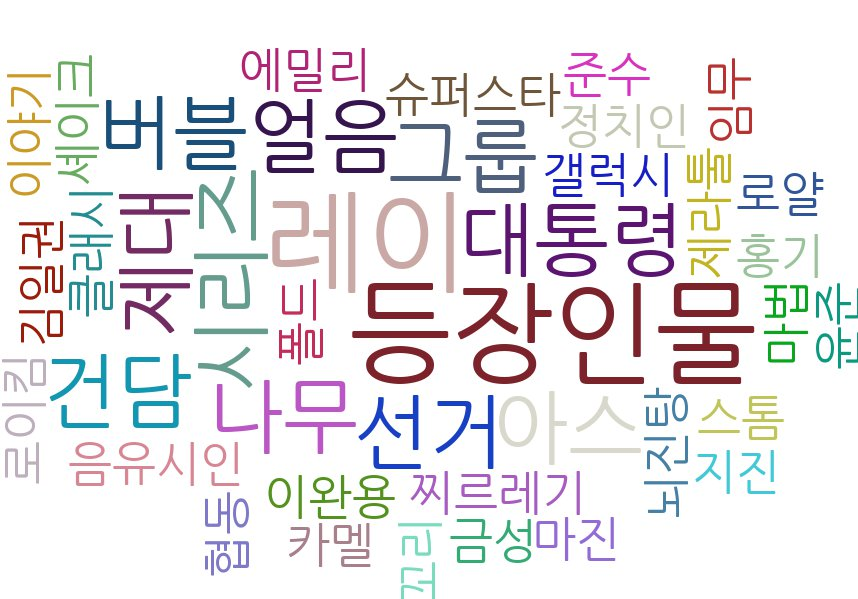

In [21]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

-----

##### 카테고리 키워드

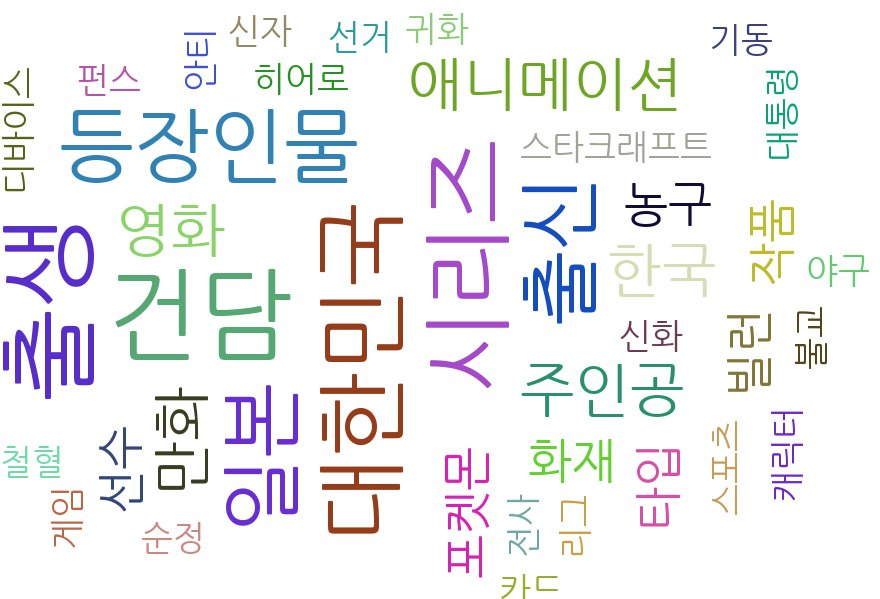

In [22]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')